# Implementación básica ARIMA

In [1]:
# Bloque de importación de dependencias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression

## Carga de datos

In [10]:
df = pd.read_csv('../data/00_original/Electric_Production.csv', parse_dates = ['DATE'])
df.columns = ['date', 'y']
df.set_index('date', inplace = True)
df

,y
date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


In [8]:
df.dtypes

DATE     datetime64[ns]
Value           float64
dtype: object

## Separación en entrenamiento, validación y test

In [11]:
val_size = 24
test_size = 24

train = df.iloc[ :-(val_size + test_size)]
val = df.iloc[-(val_size + test_size): -test_size]
test = df.iloc[-test_size:]

## Datos de entrenamiento: visualización y preprocesamiento

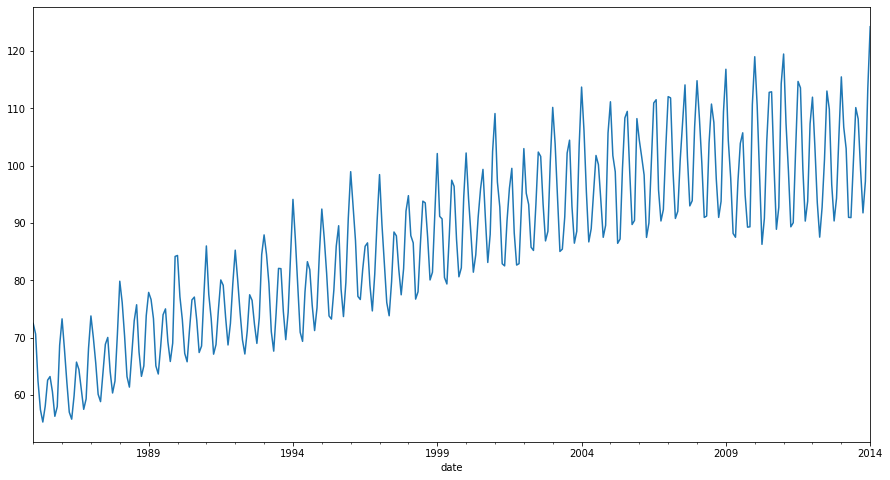

In [13]:
fig, ax = plt.subplots(figsize=(15, 8))
train['y'].plot();

### Análisis de homocedasticidad

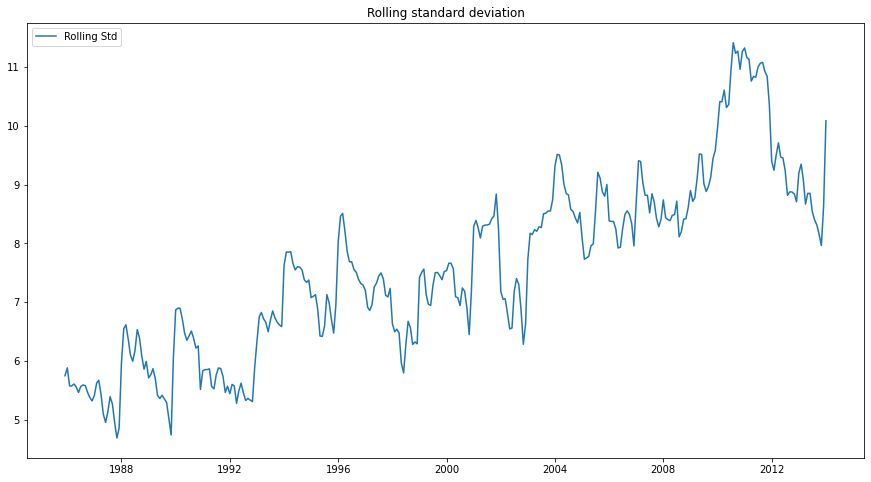

In [14]:
rolling_std = train['y'].rolling(window = 12).std()

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(rolling_std, label = 'Rolling Std')
ax.legend(loc='upper left')
ax.set_title('Rolling standard deviation')
plt.show()

Aplicamos una transformación logarítmica para estabilizar la varianza.

In [19]:
train_log = pd.DataFrame(np.log(train['y']))
train_log

,y
date,
1985-01-01,4.283658
1985-02-01,4.258049
1985-03-01,4.134369
1985-04-01,4.051287
1985-05-01,4.013046
...,...
2013-09-01,4.597953
2013-10-01,4.519472
2013-11-01,4.577648


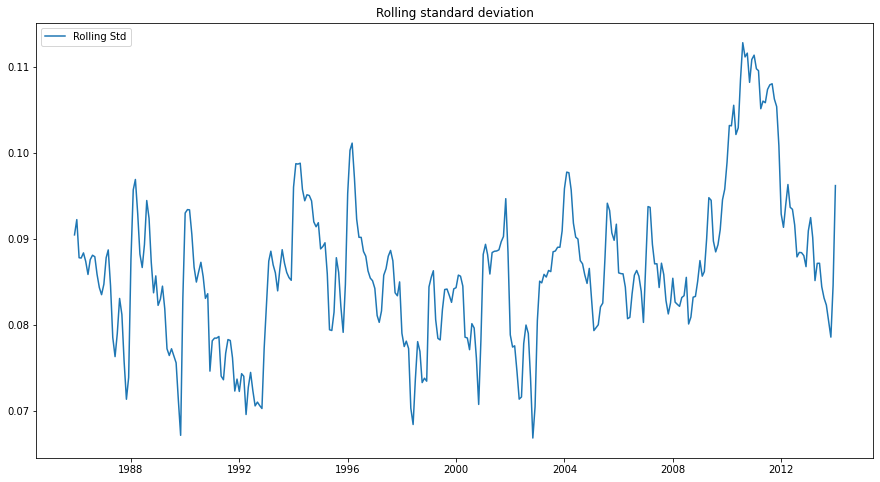

In [21]:
rolling_std = train_log['y'].rolling(window = 12).std()

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(rolling_std, label = 'Rolling Std')
ax.legend(loc='upper left')
ax.set_title('Rolling standard deviation')
plt.show()

## Ajuste ARIMA

### Parámetro d

In [22]:
# Aplicación de diferenciación, para un d dado
def apply_diff(df, d):
  for i in range(d):
    df['y'] = df['y'].diff(1)
  return df


# Cálculo del valor óptimo de d
def get_optimal_d(df):
  df_temp = df.copy()
  d = 0
  threshold = 0.05
  while True:
    if adfuller(df_temp['y'].dropna())[1] > threshold:
      d += 1
      df_temp = apply_diff(df_temp, 1)
    else:
      break
  return d

In [23]:
d = get_optimal_d(train_log)
d

1

In [24]:
train_log_diff = pd.DataFrame(train_log.diff(1))
train_log_diff

,y
date,
1985-01-01,NaN
1985-02-01,-0.025609
1985-03-01,-0.123680
1985-04-01,-0.083082
1985-05-01,-0.038242
...,...
2013-09-01,-0.085803
2013-10-01,-0.078481
2013-11-01,0.058176


### Parámetros p y q